## PII Detection and Masking using BiLSTM + CRF

**Personally Identifiable Information (PII)** refers to any data that can identify an individual, such as names, phone numbers, emails, addresses, or social security numbers.
Protecting PII is essential for **data privacy**, **regulatory compliance (GDPR, HIPAA, CCPA)**, and **building safe AI systems**.

In this notebook, we will:

1. **Identify PII** from raw text using a **BiLSTM + CRF sequence labeling model**.
2. **Mask or anonymize** sensitive information without altering the natural flow of the text.
3. **Train a Named Entity Recognition (NER)-style model** to detect multiple PII types effectively.

---

### **Dataset Overview**

We use the **AI4Privacy-PII dataset**, which contains:

* **Raw and masked text pairs**.
* **Token-level BIO tags** for multiple PII categories (e.g., `FIRSTNAME`, `PHONENUMBER`, `EMAIL`, `ADDRESS`).

**Example:**

| Original Text                                       | Masked Output                                                    |
| --------------------------------------------------- | ---------------------------------------------------------------- |
| "My name is Sarah and my phone number is 555-1234." | "My name is \[FIRSTNAME] and my phone number is \[PHONENUMBER]." |

Each token in the sentence is labeled using the **BIO tagging scheme**:

* **O** → Non-PII token
* **B-XXX** → Beginning of a PII entity
* **I-XXX** → Inside a PII entity

---

This notebook will guide you through:

1. **Loading & Examining the Dataset** – Understanding the PII labels and text structure.
2. **Preprocessing & Tokenization** – Converting raw text into token IDs with BIO labels.
3. **Model Training** – Training a **BiLSTM + CRF model** for sequence labeling.
4. **Evaluation & Metrics** – Using accuracy, precision, recall, and F1-score to measure performance.
5. **PII Masking Inference** – Automatically replacing detected PII with placeholders.

---

By the end of this notebook, you will have:

A **trained BiLSTM + CRF model** for PII detection.
A **reproducible Kaggle workflow** for token-level NER tasks.

#### Tools

In [1]:
!pip install pytorch-crf -q

In [2]:
import collections
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import torch.nn as nn
from torchcrf import CRF

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from datasets import load_dataset
from transformers import BertTokenizerFast

## EDA

In [3]:
dataset = load_dataset("json", data_files="/kaggle/input/ai4privacy-pii/pii-masking-200k/english_pii_43k.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text'],
        num_rows: 43501
    })
})

In [5]:
train_ds = dataset['train']

In [6]:
print(train_ds[0])

{'masked_text': "A student's assessment was found on device bearing IMEI: [PHONEIMEI_1]. The document falls under the various topics discussed in our [JOBAREA_1] curriculum. Can you please collect it?", 'unmasked_text': "A student's assessment was found on device bearing IMEI: 06-184755-866851-3. The document falls under the various topics discussed in our Optimization curriculum. Can you please collect it?", 'privacy_mask': "{'[PHONEIMEI_1]': '06-184755-866851-3', '[JOBAREA_1]': 'Optimization'}", 'span_labels': "[[0, 57, 'O'], [57, 75, 'PHONEIMEI_1'], [75, 138, 'O'], [138, 150, 'JOBAREA_1'], [150, 189, 'O']]", 'bio_labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'I-PHONEIMEI', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-JOBAREA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'tokenised_text': ['a', 'st

Extract all PII labels found in the dataset

In [7]:
label_list = sorted(set(sum(train_ds['bio_labels'], [])))

In [8]:
label_list

['B-ACCOUNTNAME',
 'B-ACCOUNTNUMBER',
 'B-AGE',
 'B-AMOUNT',
 'B-BIC',
 'B-BITCOINADDRESS',
 'B-BUILDINGNUMBER',
 'B-CITY',
 'B-COMPANYNAME',
 'B-COUNTY',
 'B-CREDITCARDCVV',
 'B-CREDITCARDISSUER',
 'B-CREDITCARDNUMBER',
 'B-CURRENCY',
 'B-CURRENCYCODE',
 'B-CURRENCYNAME',
 'B-CURRENCYSYMBOL',
 'B-DATE',
 'B-DOB',
 'B-EMAIL',
 'B-ETHEREUMADDRESS',
 'B-EYECOLOR',
 'B-FIRSTNAME',
 'B-GENDER',
 'B-HEIGHT',
 'B-IBAN',
 'B-IP',
 'B-IPV4',
 'B-IPV6',
 'B-JOBAREA',
 'B-JOBTITLE',
 'B-JOBTYPE',
 'B-LASTNAME',
 'B-LITECOINADDRESS',
 'B-MAC',
 'B-MASKEDNUMBER',
 'B-MIDDLENAME',
 'B-NEARBYGPSCOORDINATE',
 'B-ORDINALDIRECTION',
 'B-PASSWORD',
 'B-PHONEIMEI',
 'B-PHONENUMBER',
 'B-PIN',
 'B-PREFIX',
 'B-SECONDARYADDRESS',
 'B-SEX',
 'B-SSN',
 'B-STATE',
 'B-STREET',
 'B-TIME',
 'B-URL',
 'B-USERAGENT',
 'B-USERNAME',
 'B-VEHICLEVIN',
 'B-VEHICLEVRM',
 'B-ZIPCODE',
 'I-ACCOUNTNAME',
 'I-ACCOUNTNUMBER',
 'I-AGE',
 'I-AMOUNT',
 'I-BIC',
 'I-BITCOINADDRESS',
 'I-BUILDINGNUMBER',
 'I-CITY',
 'I-COMPANYN

Map them to label2id and id2label

In [9]:
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

In [10]:
#id2label

In [11]:
# label2id

In [12]:
print("Number of rows:", len(train_ds))

Number of rows: 43501


In [13]:
print("Features:", train_ds.features)

Features: {'masked_text': Value(dtype='string', id=None), 'unmasked_text': Value(dtype='string', id=None), 'privacy_mask': Value(dtype='string', id=None), 'span_labels': Value(dtype='string', id=None), 'bio_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'tokenised_text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}


In [14]:
df = train_ds.to_pandas()

In [15]:
df

,masked_text,unmasked_text,privacy_mask,span_labels,bio_labels,tokenised_text
0,A student's assessment was found on device bea...,A student's assessment was found on device bea...,"{'[PHONEIMEI_1]': '06-184755-866851-3', '[JOBA...","[[0, 57, 'O'], [57, 75, 'PHONEIMEI_1'], [75, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PHON...","[a, student, ', s, assessment, was, found, on,..."
1,"Dear [FIRSTNAME_1], as per our records, your l...","Dear Omer, as per our records, your license 78...","{'[FIRSTNAME_1]': 'Omer', '[VEHICLEVIN_1]': '7...","[[0, 5, 'O'], [5, 9, 'FIRSTNAME_1'], [9, 44, '...","[O, B-FIRSTNAME, I-FIRSTNAME, O, O, O, O, O, O...","[dear, om, ##er, ,, as, per, our, records, ,, ..."
2,[FIRSTNAME_1] could you please share your reco...,Kattie could you please share your recomndatio...,"{'[FIRSTNAME_1]': 'Kattie', '[AGE_1]': '72', '...","[[0, 6, 'FIRSTNAME_1'], [6, 75, 'O'], [75, 77,...","[B-FIRSTNAME, I-FIRSTNAME, O, O, O, O, O, O, O...","[kat, ##tie, could, you, please, share, your, ..."
3,Emergency supplies in [BUILDINGNUMBER_1] need ...,Emergency supplies in 16356 need a refill. Use...,"{'[BUILDINGNUMBER_1]': '16356', '[MASKEDNUMBER...","[[0, 22, 'O'], [22, 27, 'BUILDINGNUMBER_1'], [...","[O, O, O, B-BUILDINGNUMBER, I-BUILDINGNUMBER, ...","[emergency, supplies, in, 1635, ##6, need, a, ..."
4,"The [AGE_1] old child at [BUILDINGNUMBER_1], h...","The 88 old child at 5862, has showcased an unu...","{'[AGE_1]': '88', '[BUILDINGNUMBER_1]': '5862'...","[[0, 4, 'O'], [4, 6, 'AGE_1'], [6, 20, 'O'], [...","[O, B-AGE, O, O, O, B-BUILDINGNUMBER, I-BUILDI...","[the, 88, old, child, at, 58, ##6, ##2, ,, has..."
...,...,...,...,...,...,...
43496,"Hello [FIRSTNAME_1], your cognitive therapy ap...","Hello Nellie, your cognitive therapy appointme...","{'[FIRSTNAME_1]': 'Nellie', '[DATE_1]': '8/21'...","[[0, 6, 'O'], [6, 12, 'FIRSTNAME_1'], [12, 66,...","[O, B-FIRSTNAME, O, O, O, O, O, O, O, O, B-DAT...","[hello, nellie, ,, your, cognitive, therapy, a..."
43497,"Dear [FIRSTNAME_1], we appreciate your active ...","Dear Jalon, we appreciate your active involvem...","{'[FIRSTNAME_1]': 'Jalon', '[CREDITCARDNUMBER_...","[[0, 5, 'O'], [5, 10, 'FIRSTNAME_1'], [10, 159...","[O, B-FIRSTNAME, I-FIRSTNAME, O, O, O, O, O, O...","[dear, ja, ##lon, ,, we, appreciate, your, act..."
43498,"Dear [SEX_1] at [ZIPCODE_1], we are raising fu...","Dear Female at 32363-2779, we are raising fund...","{'[SEX_1]': 'Female', '[ZIPCODE_1]': '32363-27...","[[0, 5, 'O'], [5, 11, 'SEX_1'], [11, 15, 'O'],...","[O, B-SEX, O, B-ZIPCODE, I-ZIPCODE, I-ZIPCODE,...","[dear, female, at, 323, ##6, ##3, -, 277, ##9,..."
43499,"Hello [FIRSTNAME_1], we encourage you to pay t...","Hello Tito, we encourage you to pay the fees o...","{'[FIRSTNAME_1]': 'Tito', '[ETHEREUMADDRESS_1]...","[[0, 6, 'O'], [6, 10, 'FIRSTNAME_1'], [10, 137...","[O, B-FIRSTNAME, O, O, O, O, O, O, O, O, O, O,...","[hello, tito, ,, we, encourage, you, to, pay, ..."


Add char_length and token_length columns for visualizations.

In [16]:
df["char_length"] = df["unmasked_text"].str.len()
df["token_length"] = df["tokenised_text"].apply(len)

array([[<Axes: title={'center': 'char_length'}>,
        <Axes: title={'center': 'token_length'}>]], dtype=object)

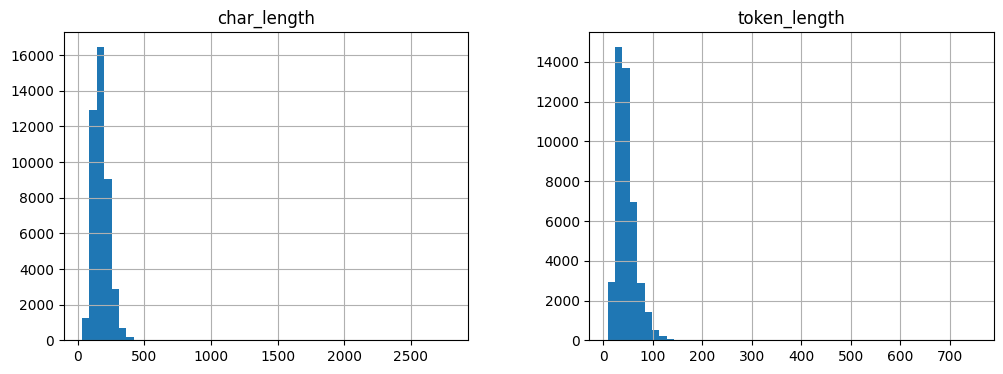

In [17]:
df[["char_length","token_length"]].hist(bins=50, figsize=(12,4))


We can spot that most samples has a token_length lower than 150 and char length lower than 500 chars.

Visualize the most used k Entities found in the dataset.

In [18]:
k = 20

In [19]:
all_labels = [label for row in df["bio_labels"] for label in row if label != "O"]
label_counts = dict(Counter(all_labels).most_common(k))
label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

In [20]:
label_counts

{'I-USERAGENT': 89432,
 'I-IPV6': 70585,
 'I-BITCOINADDRESS': 53492,
 'I-ETHEREUMADDRESS': 47560,
 'I-IP': 36166,
 'I-EMAIL': 34344,
 'I-URL': 28220,
 'I-IBAN': 27658,
 'I-CREDITCARDNUMBER': 22036,
 'I-DATE': 21905,
 'I-PHONEIMEI': 20351,
 'I-PASSWORD': 19907,
 'I-NEARBYGPSCOORDINATE': 18824,
 'I-MASKEDNUMBER': 17981,
 'I-PHONENUMBER': 17379,
 'I-LITECOINADDRESS': 16800,
 'I-IPV4': 16322,
 'I-MAC': 14053,
 'B-FIRSTNAME': 13286,
 'I-COMPANYNAME': 11875}

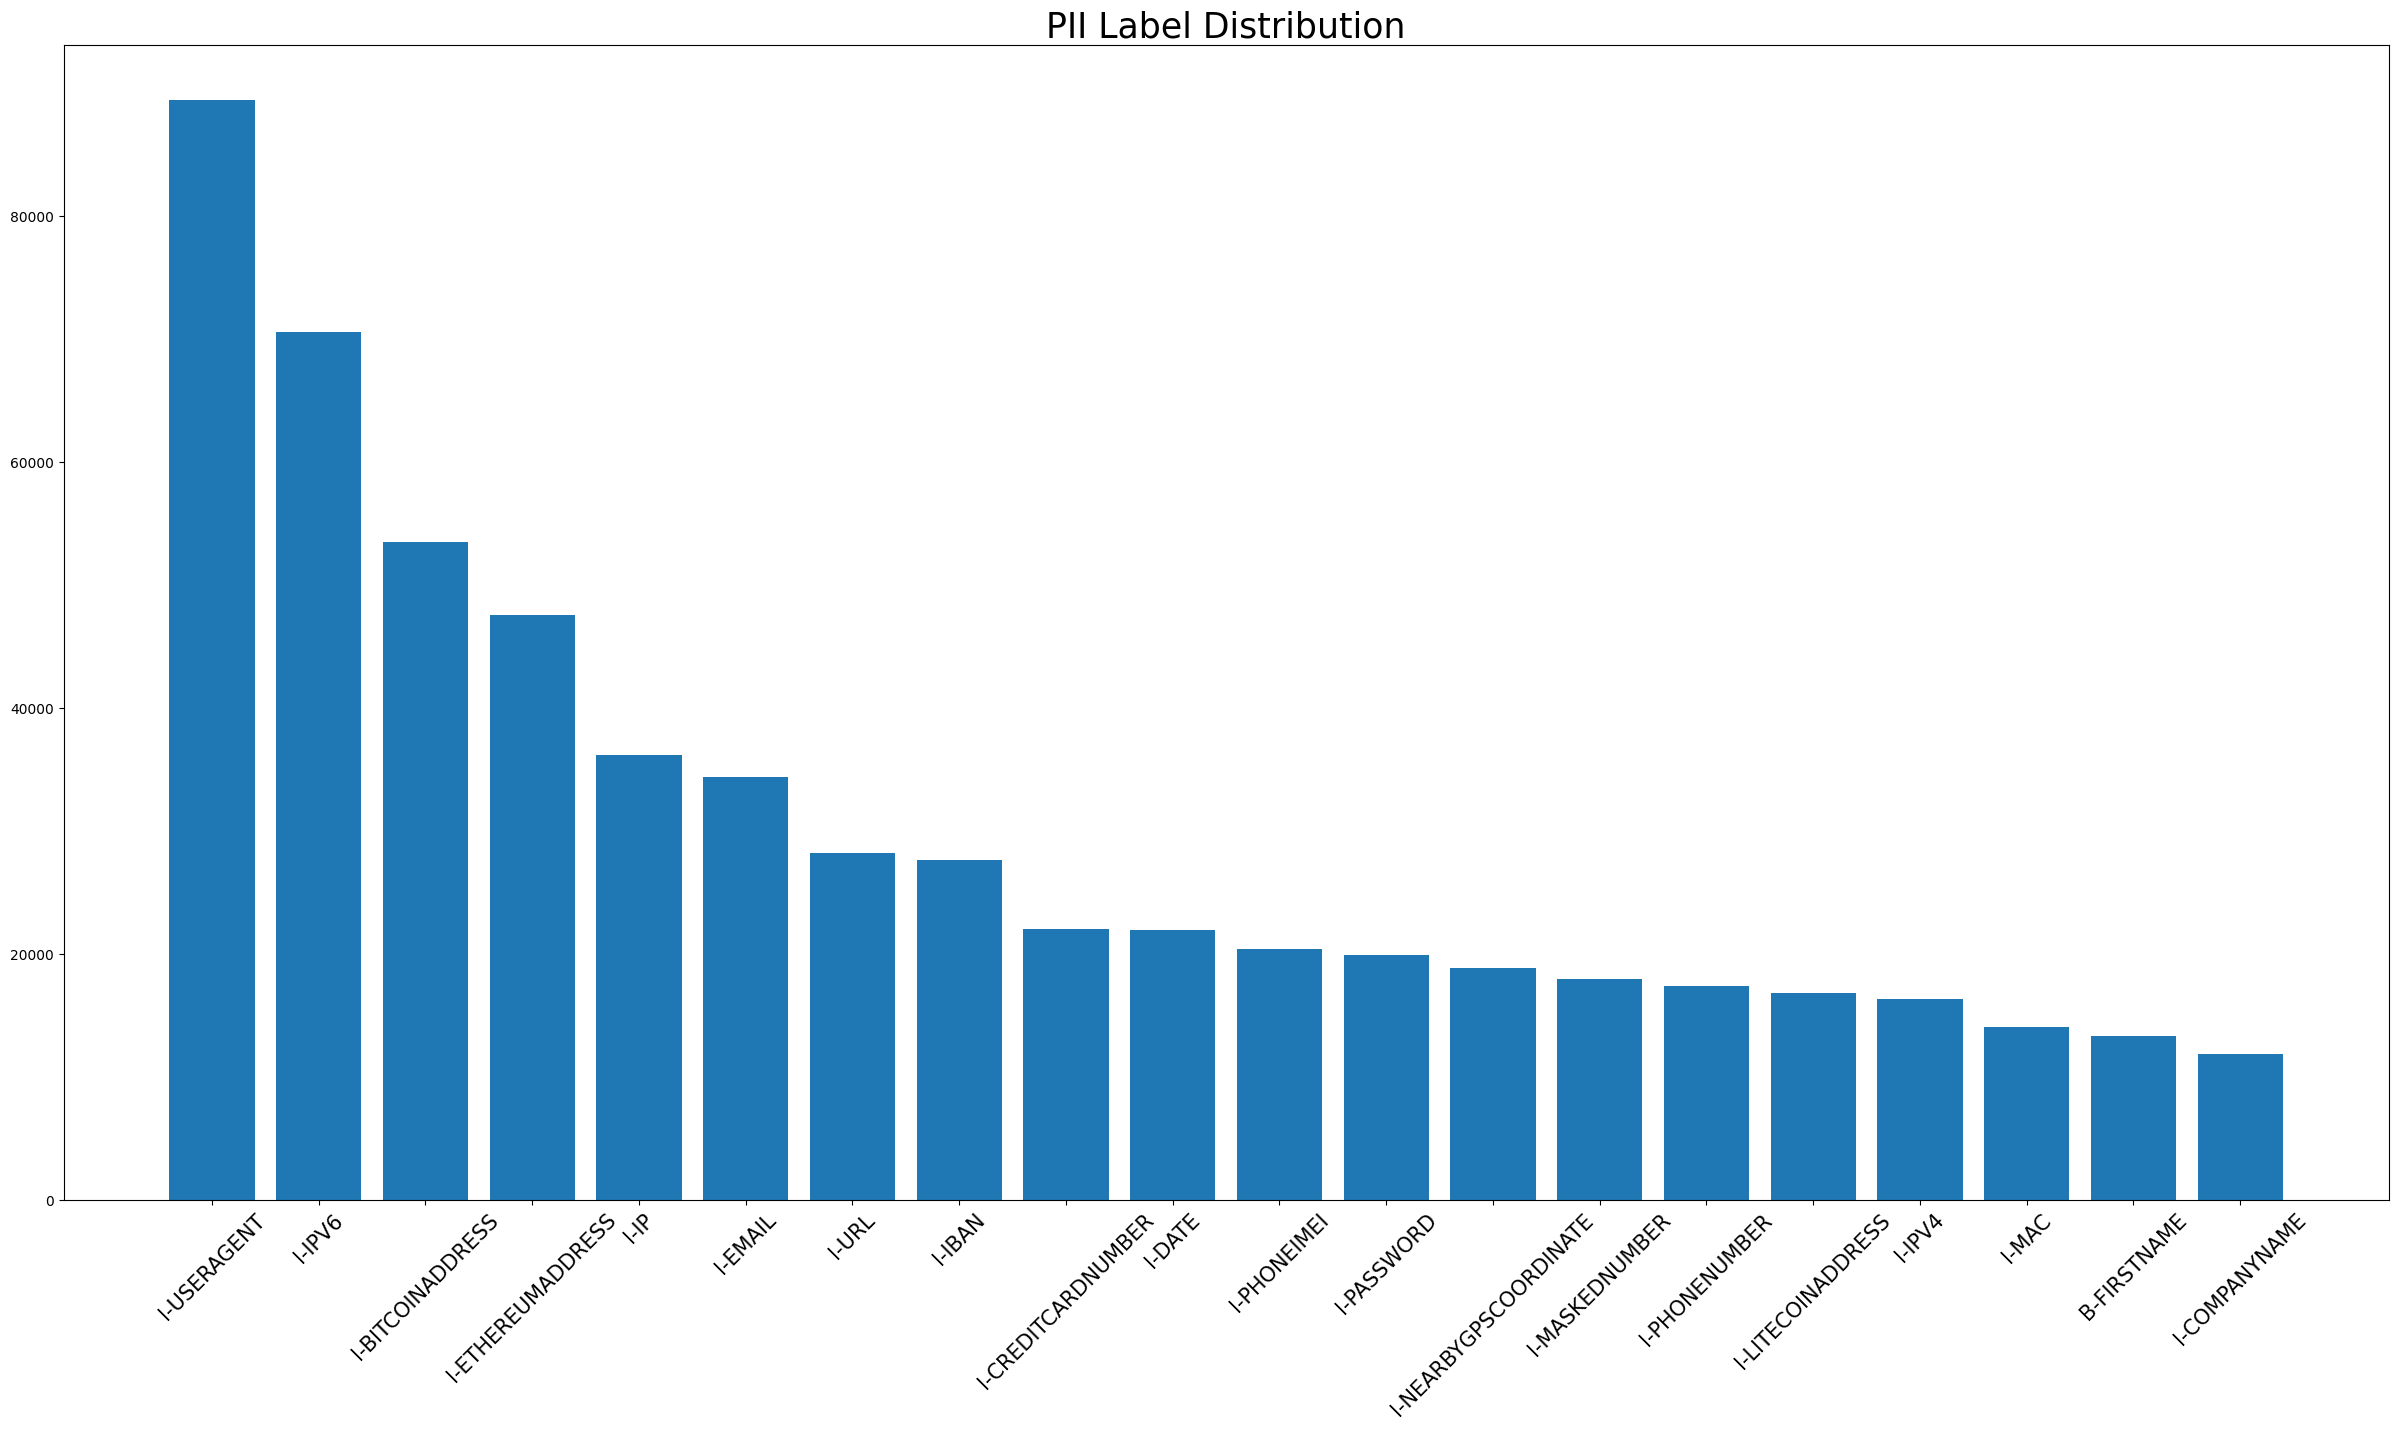

In [21]:
plt.figure(figsize=(30,15))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45, fontsize=15)
plt.title("PII Label Distribution", fontsize=25)
plt.show()


#### Show some samples

In [22]:
sample = df.sample(3, random_state=42)
for i, row in sample.iterrows():
    print("Masked Text:", row["masked_text"])
    print("Unmasked Text:", row["unmasked_text"])
    print("PII Entities:", row["privacy_mask"])
    print("="*80)
    print('\n\n')


Masked Text: [IPV6_1] has been performing illegal transactions involving [BITCOINADDRESS_1]. As a [JOBTYPE_1], your help is needed in this matter.
Unmasked Text: 750a:12ac:c7dc:88ee:51e5:57ee:59ca:09b7 has been performing illegal transactions involving 1XaB1qDUEneQ87PYHtMDXZwPj59xzP9DX7J7R4SM. As a Associate, your help is needed in this matter.
PII Entities: {'[IPV6_1]': '750a:12ac:c7dc:88ee:51e5:57ee:59ca:09b7', '[BITCOINADDRESS_1]': '1XaB1qDUEneQ87PYHtMDXZwPj59xzP9DX7J7R4SM', '[JOBTYPE_1]': 'Associate'}



Masked Text: Dr. [LASTNAME_1], you need to check the data from the device with MAC address: [MAC_1].
Unmasked Text: Dr. Heller-Russel, you need to check the data from the device with MAC address: 46:86:ea:1a:b8:93.
PII Entities: {'[LASTNAME_1]': 'Heller-Russel', '[MAC_1]': '46:86:ea:1a:b8:93'}



Masked Text: Regarding the supply chain network, I've noticed discrepancies in the Litecoin Address paired with [IPV6_1]. Can we confirm this with [USERNAME_1]?
Unmasked Text: Regarding th

## Data preprocessing

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The dataset was tokenized using bert-base-uncased tokenizer, so I will use it as well for inference. Also it will be used to get the token2id vocab.

In [24]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
token2id = tokenizer.get_vocab()

In [26]:
len(token2id)

30522

Create label2id mapping, and use -100 as our pad label

In [27]:
all_labels = sorted(set(lbl for row in df["bio_labels"] for lbl in row))
label2id = {lbl: idx for idx, lbl in enumerate(all_labels)}
PAD_LABEL = -100 

In [28]:
label2id

{'B-ACCOUNTNAME': 0,
 'B-ACCOUNTNUMBER': 1,
 'B-AGE': 2,
 'B-AMOUNT': 3,
 'B-BIC': 4,
 'B-BITCOINADDRESS': 5,
 'B-BUILDINGNUMBER': 6,
 'B-CITY': 7,
 'B-COMPANYNAME': 8,
 'B-COUNTY': 9,
 'B-CREDITCARDCVV': 10,
 'B-CREDITCARDISSUER': 11,
 'B-CREDITCARDNUMBER': 12,
 'B-CURRENCY': 13,
 'B-CURRENCYCODE': 14,
 'B-CURRENCYNAME': 15,
 'B-CURRENCYSYMBOL': 16,
 'B-DATE': 17,
 'B-DOB': 18,
 'B-EMAIL': 19,
 'B-ETHEREUMADDRESS': 20,
 'B-EYECOLOR': 21,
 'B-FIRSTNAME': 22,
 'B-GENDER': 23,
 'B-HEIGHT': 24,
 'B-IBAN': 25,
 'B-IP': 26,
 'B-IPV4': 27,
 'B-IPV6': 28,
 'B-JOBAREA': 29,
 'B-JOBTITLE': 30,
 'B-JOBTYPE': 31,
 'B-LASTNAME': 32,
 'B-LITECOINADDRESS': 33,
 'B-MAC': 34,
 'B-MASKEDNUMBER': 35,
 'B-MIDDLENAME': 36,
 'B-NEARBYGPSCOORDINATE': 37,
 'B-ORDINALDIRECTION': 38,
 'B-PASSWORD': 39,
 'B-PHONEIMEI': 40,
 'B-PHONENUMBER': 41,
 'B-PIN': 42,
 'B-PREFIX': 43,
 'B-SECONDARYADDRESS': 44,
 'B-SEX': 45,
 'B-SSN': 46,
 'B-STATE': 47,
 'B-STREET': 48,
 'B-TIME': 49,
 'B-URL': 50,
 'B-USERAGENT': 51,
 

Convert samples sequences to ID lists


**The next code works as following:**

*Original tokens & labels*

| Tokens                    | Labels                |
| ------------------------- | --------------------- |
| `I` `live` `in` `Paris`   | `O` `O` `O` `B-CITY`  |
| `My` `phone` `is` `12345` | `O` `O` `O` `B-PHONE` |

---

*Converted IDs*

```text
X_ids = [
    [2, 3, 4, 5],     # 'I' -> 2, 'live' -> 3, 'in' -> 4, 'Paris' -> 5
    [6, 7, 8, 9]      # 'My' -> 6, 'phone' -> 7, 'is' -> 8, '12345' -> 9
]

y_ids = [
    [0, 0, 0, 1],     # 'O' -> 0, 'B-CITY' -> 1
    [0, 0, 0, 2]      # 'O' -> 0, 'B-PHONE' -> 2
]
```



In [29]:
PAD_INPUT = token2id["[PAD]"]
UNK_INPUT = token2id["[UNK]"]

In [30]:
X_ids = [[token2id.get(tok, UNK_INPUT) for tok in row] for row in df["tokenised_text"]]
y_ids = [[label2id[label] for label in row] for row in df["bio_labels"]]

Based on the analysis, The following max_len will be better for the model trining as most of the samples does not exceed it.

In [31]:
MAX_LEN = 256 

Apply padding to the ids sequences to produce a X_paaded and a y_padded tensors that has a shape of (samples_number x MAX_LEN)

In [32]:
X_padded = np.full((len(X_ids), MAX_LEN), PAD_INPUT, dtype=np.int64)
y_padded = np.full((len(y_ids), MAX_LEN), PAD_LABEL, dtype=np.int64)

for i, (x_seq, y_seq) in enumerate(zip(X_ids, y_ids)):
    X_padded[i, :len(x_seq[:MAX_LEN])] = x_seq[:MAX_LEN]
    y_padded[i, :len(y_seq[:MAX_LEN])] = y_seq[:MAX_LEN]


After thatm we need to convert numpy.ndarray to torch.Tensor, to apply the TensorDataset, then random_split.

In [33]:
type(X_padded)

numpy.ndarray

In [34]:
X_tensor = torch.tensor(X_padded, dtype=torch.long)
y_tensor = torch.tensor(y_padded, dtype=torch.long)

In [35]:
type(X_tensor)

torch.Tensor

split into train and test splits.

In [36]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Create Data loaders

In [37]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Model Selection

Inititalize The model, which is a bi LSTM model with a crf layer in it.

In [38]:
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, pad_idx=0, pad_label_id=-100):
        super().__init__()
        self.pad_label_id = pad_label_id
        
        # Embedding layer for tokens
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        
        # Linear layer for projecting to label space
        self.hidden2tag = nn.Linear(hidden_dim * 2, num_labels)
        
        # CRF layer
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, tags=None, mask=None):
        embeds = self.embedding(input_ids)            # [B, L, E]
        lstm_out, _ = self.lstm(embeds)               # [B, L, 2*H]
        emissions = self.hidden2tag(lstm_out)         # [B, L, num_labels]
        
        if tags is not None:
            # Convert ignored labels to 0 for CRF
            crf_tags = tags.clone()
            crf_tags[crf_tags == self.pad_label_id] = 0
            
            # Negative log likelihood
            loss = -self.crf(emissions, crf_tags, mask=mask, reduction='mean')
            return loss
        else:
            # Decode (Viterbi) paths
            return self.crf.decode(emissions, mask=mask)


Define main arguments for the model, including hidden_dim

In [39]:
vocab_size = len(token2id)
embedding_dim = 128
hidden_dim = 256
num_labels = len(label2id)

In [40]:
num_labels

111

In [41]:
model = BiLSTMCRF(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_labels=num_labels,
    pad_idx=PAD_INPUT,
    pad_label_id=PAD_LABEL
).to(device)

## Testing a sample before training

In [42]:
sample_text = (
    "Hello, my name is Sarah Johnson. "
    "I live at 42 Maple Street, New York, and my email is sarah.j@gmail.com. "
    "My phone number is 555-1234."
)


In [43]:

encoding_temp = tokenizer(
    sample_text,
    truncation=True,
    padding="max_length",   
    max_length=MAX_LEN,
    return_tensors="pt",
    is_split_into_words=False
)


X_temp = encoding_temp["input_ids"].to(device)
mask_temp = encoding_temp["attention_mask"].bool().to(device)


model.eval()
with torch.no_grad():
    pred_ids_temp = model(X_temp, mask=mask_temp)[0]


seq_len_temp = mask_temp[0].sum().item()
pred_ids_temp = pred_ids_temp[:seq_len_temp]

id2label = {v: k for k, v in label2id.items()}
pred_labels_temp = [id2label.get(lbl_id, "O") for lbl_id in pred_ids_temp]

tokens_temp = tokenizer.convert_ids_to_tokens(X_temp[0])[:seq_len_temp]

print("\n=== Sample Inference Output (Untrained) ===")
print("| Token          | Predicted Label |")
print("|----------------|----------------|")
for tok, lbl in zip(tokens_temp, pred_labels_temp):
    print(f"| {tok:14s} | {lbl:14s} |")



=== Sample Inference Output (Untrained) ===
| Token          | Predicted Label |
|----------------|----------------|
| [CLS]          | B-IPV4         |
| hello          | B-IBAN         |
| ,              | B-EYECOLOR     |
| my             | I-FIRSTNAME    |
| name           | I-USERNAME     |
| is             | B-CURRENCY     |
| sarah          | I-COUNTY       |
| johnson        | B-VEHICLEVRM   |
| .              | I-COUNTY       |
| i              | B-CURRENCYNAME |
| live           | I-MAC          |
| at             | B-GENDER       |
| 42             | B-DATE         |
| maple          | I-AMOUNT       |
| street         | B-JOBTITLE     |
| ,              | B-ETHEREUMADDRESS |
| new            | I-CURRENCYCODE |
| york           | B-GENDER       |
| ,              | I-SSN          |
| and            | I-CURRENCYNAME |
| my             | I-CURRENCYNAME |
| email          | I-CURRENCYNAME |
| is             | B-IP           |
| sarah          | B-AGE          |
| .            

Before training the model, we get a very bad results, the model can not even recongize first and last name.

## Model Training

Create metrics function that will be used with test split.

In [44]:
def flat_metrics(all_true, all_pred, PAD_LABEL=-100):
    y_true_flat, y_pred_flat = [], []
    for true_seq, pred_seq in zip(all_true, all_pred):
        # remove PADs
        true_seq = [lbl for lbl in true_seq if lbl != PAD_LABEL]
        pred_seq = pred_seq[:len(true_seq)]  # align lengths
        y_true_flat.extend(true_seq)
        y_pred_flat.extend(pred_seq)
    return y_true_flat, y_pred_flat

In [45]:
model = model.to(device)

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [47]:
EPOCHS = 5

In [48]:
best_f1 = -np.inf

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
    
    # ---- TRAIN ----
    model.train()
    total_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Training {epoch+1}/{EPOCHS}", leave=False)

    for X_batch, y_batch in train_loader_tqdm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask = (X_batch != PAD_INPUT)

        optimizer.zero_grad()
        loss = model(X_batch, y_batch, mask)  # forward returns loss when tags are passed
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loader_tqdm.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}")

    # ---- EVALUATE ON TEST SET ----
    model.eval()
    all_true, all_pred = [], []
    total_test_loss = 0.0
    test_loader_tqdm = tqdm(test_loader, desc=f"Evaluating {epoch+1}/{EPOCHS}", leave=False)

    with torch.no_grad():
        for X_batch, y_batch in test_loader_tqdm:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mask = (X_batch != PAD_INPUT)

            # Compute loss
            loss = model(X_batch, y_batch, mask)
            total_test_loss += loss.item()

            # Decode predictions
            predictions = model(X_batch, mask=mask)  # decode mode
            y_true = y_batch.cpu().tolist()

            for t, p in zip(y_true, predictions):
                all_true.append(t)
                all_pred.append(p)
            
            test_loader_tqdm.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_test_loss = total_test_loss / len(test_loader)

    # Flatten sequences ignoring PAD labels (-100)
    y_true_flat, y_pred_flat = flat_metrics(all_true, all_pred)

    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

    print(f"Test Loss: {avg_test_loss:.4f} | Acc: {acc:.4f} | "
          f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # ---- SAVE ONLY BEST MODEL ----
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model, "best_bilstm_crf_model.pt")
        print(f"New best model saved with F1={best_f1:.4f} -> best_bilstm_crf_model.pt")



=== Epoch 1/5 ===


Train Loss: 20.0645


Test Loss: 5.3088 | Acc: 0.9345 | Precision: 0.8681 | Recall: 0.8083 | F1: 0.8264
New best model saved with F1=0.8264 -> best_bilstm_crf_model.pt

=== Epoch 2/5 ===


Train Loss: 3.6001


Test Loss: 3.0600 | Acc: 0.9503 | Precision: 0.8957 | Recall: 0.8752 | F1: 0.8781
New best model saved with F1=0.8781 -> best_bilstm_crf_model.pt

=== Epoch 3/5 ===


Train Loss: 1.8563


Test Loss: 2.2379 | Acc: 0.9552 | Precision: 0.9125 | Recall: 0.8896 | F1: 0.8946
New best model saved with F1=0.8946 -> best_bilstm_crf_model.pt

=== Epoch 4/5 ===


Train Loss: 1.1443


Test Loss: 1.8105 | Acc: 0.9562 | Precision: 0.9105 | Recall: 0.8987 | F1: 0.8985
New best model saved with F1=0.8985 -> best_bilstm_crf_model.pt

=== Epoch 5/5 ===


Train Loss: 0.8319


Test Loss: 1.7057 | Acc: 0.9566 | Precision: 0.9110 | Recall: 0.9032 | F1: 0.9054
New best model saved with F1=0.9054 -> best_bilstm_crf_model.pt


As we can see, there is a huge improvment in the performance of the model, with f1-score of ~91%

## Testing a sample After training

In [49]:
encoding_temp = tokenizer(
    sample_text,
    truncation=True,
    padding="max_length",   
    max_length=MAX_LEN,
    return_tensors="pt",
    is_split_into_words=False
)


X_temp = encoding_temp["input_ids"].to(device)
mask_temp = encoding_temp["attention_mask"].bool().to(device)


model.eval()
with torch.no_grad():
    pred_ids_temp = model(X_temp, mask=mask_temp)[0]


seq_len_temp = mask_temp[0].sum().item()
pred_ids_temp = pred_ids_temp[:seq_len_temp]

id2label = {v: k for k, v in label2id.items()}
pred_labels_temp = [id2label.get(lbl_id, "O") for lbl_id in pred_ids_temp]

tokens_temp = tokenizer.convert_ids_to_tokens(X_temp[0])[:seq_len_temp]

print("\n=== Sample Inference Output (Untrained) ===")
print("| Token          | Predicted Label |")
print("|----------------|----------------|")
for tok, lbl in zip(tokens_temp, pred_labels_temp):
    print(f"| {tok:14s} | {lbl:14s} |")



=== Sample Inference Output (Untrained) ===
| Token          | Predicted Label |
|----------------|----------------|
| [CLS]          | O              |
| hello          | O              |
| ,              | O              |
| my             | O              |
| name           | O              |
| is             | O              |
| sarah          | B-FIRSTNAME    |
| johnson        | B-LASTNAME     |
| .              | O              |
| i              | O              |
| live           | O              |
| at             | O              |
| 42             | B-BUILDINGNUMBER |
| maple          | B-STREET       |
| street         | I-STREET       |
| ,              | O              |
| new            | B-STATE        |
| york           | I-STATE        |
| ,              | O              |
| and            | O              |
| my             | O              |
| email          | O              |
| is             | O              |
| sarah          | B-EMAIL        |
| .             

The model can correctly Identify the PII information of the text provided, along with the normal text objects as O

## Thank you